In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

In [2]:
DEBUG = True

In [3]:
# Utility functions
def save_to_output(img, original_file, subdir, base_name):
    if DEBUG:
        subdir_path = "output_images/{}".format(subdir)
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)

        output_file = os.path.join(subdir_path,"{}_{}".format(base_name, os.path.basename(original_file)))
        mpimg.imsave(output_file, img)
    
def plot_img(img, title):
    fig = plt.figure()
    fig.suptitle(title)
    plt.imshow(img)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
# Calibrate camera
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for image_file in images:
    img = mpimg.imread(image_file)
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    corners_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    save_to_output(corners_img, image_file, "camera_calibration", "calibrated")
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

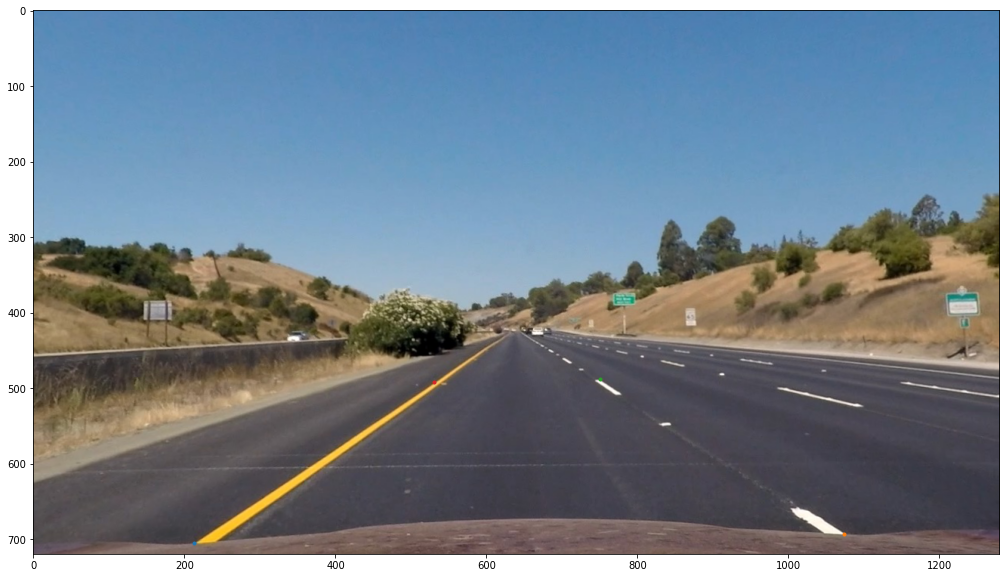

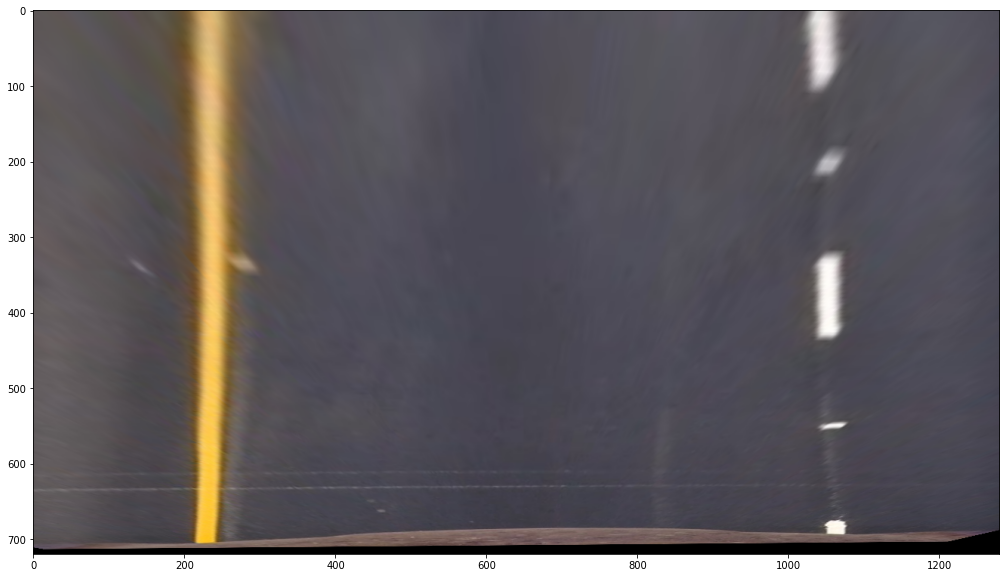

In [5]:
# Determine Perspective Transform
straight_img = mpimg.imread("test_images/straight_lines1.jpg")
undistorted = undistort(straight_img, mtx, dist)
undistorted_size = (undistorted.shape[1], undistorted.shape[0])
fig = plt.figure(figsize=(20,10))
plt.imshow(undistorted)
plt.plot(213, 705, ".")
plt.plot(1074, 693, ".")
plt.plot(750, 488, ".")
plt.plot(531, 492, ".")

src = np.float32([[213, 705], [1074, 693], [750, 488], [531, 492]])
dest = np.float32([[213, 705], [1074, 693], [1074, 317], [213, 317]])
M = cv2.getPerspectiveTransform(src, dest)
warped = cv2.warpPerspective(undistorted, M, undistorted_size, flags=cv2.INTER_LINEAR)
fig = plt.figure(figsize=(20,10))
plt.imshow(warped)

In [124]:
from collections import deque

def lines_parallel(fitx_a, fitx_b, y_step):
    line_a, ploty_a = get_points_for_poly(fitx_a, y_step)
    line_b, ploty_b = get_points_for_poly(fitx_b, y_step)
    std =  np.std(line_a - line_b)

    return std < 100

class Line():
    def __init__(self):
        self.fitx_buffer = deque(maxlen=5)
        self.fail_count = 0
        
    def add_line(self, fitx):
        self.fail_count = 0
        self.fitx_buffer.append(fitx)
        
    def get_avg_fit(self):
        return np.mean(self.fitx_buffer, axis=0)
    
    def line_found(self):
        return len(self.fitx_buffer) > 0

In [107]:
def fit_poly(leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit


def get_points_for_poly(fit, y_step):
    ploty = np.linspace(0, y_step - 1, y_step)
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fitx, ploty


def find_lane_pixels(thresh_binary):
    out_img = np.dstack((thresh_binary, thresh_binary, thresh_binary)) * 255
    left_lane_inds = []
    right_lane_inds = []
    histogram = np.sum(thresh_binary[thresh_binary.shape[0]//2:,:], axis=0)
    midpoint=int(histogram.shape[0]//2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(thresh_binary.shape[0]//nwindows)
    nonzero=thresh_binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(nwindows):
        win_y_low = thresh_binary.shape[0] - (window+1)*window_height
        win_y_high = thresh_binary.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
#         cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
#         cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))  
        
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return fit_poly(leftx, lefty, rightx, righty)


def search_around_poly(thresh_binary, left_fitx, right_fitx):
    nonzero = thresh_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fitx[0]*(nonzeroy**2) + left_fitx[1]*nonzeroy + left_fitx[2] - margin)) & \
                      (nonzerox < (left_fitx[0]*(nonzeroy**2) + left_fitx[1]*nonzeroy + left_fitx[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fitx[0]*(nonzeroy**2) + right_fitx[1]*nonzeroy + right_fitx[2] - margin)) & \
                       (nonzerox < (right_fitx[0]*(nonzeroy**2) + right_fitx[1]*nonzeroy + right_fitx[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return fit_poly(leftx, lefty, rightx, righty)

In [145]:
def sorbelx(img, sx_thresh):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary

def hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    return h_channel, l_channel, s_channel

def get_color_binary(h_channel, h_thresh, s_channel, s_thresh):
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.ones_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= s_thresh[1])] = 0
    
    color_binary = np.zeros_like(h_binary)
    color_binary[(s_binary == 1) & (h_binary == 1)] = 1
    return color_binary

In [146]:
def pipeline(img, left_line = Line(), right_line = Line()):
    s_thresh=(170, 200)
    sx_thresh=(20, 100)
    h_thresh=(0, 50)
    img = np.copy(img)
    
    undistorted = undistort(img, mtx, dist)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    
    h_channel, l_channel, s_channel = hls(warped)
    sxbinary = sorbelx(l_channel, sx_thresh)
    color_binary = get_color_binary(h_channel, h_thresh, s_channel, s_thresh)
    thresh_binary = np.zeros_like(color_binary)
    thresh_binary[(color_binary == 1) | (sxbinary == 1)] = 1
    
    if left_line.line_found() and left_line.fail_count < 5 and right_line.line_found() and right_line.fail_count < 5:
        left_fit, right_fit = search_around_poly(thresh_binary, left_line.get_avg_fit(), right_line.get_avg_fit()) 
    else:
        left_fit, right_fit = find_lane_pixels(thresh_binary)
        
    if lines_parallel(left_fit, right_fit, thresh_binary.shape[0]):
        left_line.add_line(left_fit)
        right_line.add_line(right_fit)
    else:
        left_line.fail_count += 1
        right_line.fail_count += 1
    
    # Draw region
    lane_region = np.zeros_like(undistorted)
    if left_line.line_found() and right_line.line_found():
        left_fitx, ploty = get_points_for_poly(left_line.get_avg_fit(), thresh_binary.shape[0])
        right_fitx, ploty = get_points_for_poly(right_line.get_avg_fit(), thresh_binary.shape[0])
        left_pts = np.column_stack((left_fitx, ploty))
        right_pts = np.flipud(np.column_stack((right_fitx, ploty)))
        window_pts = np.int_([np.concatenate((left_pts, right_pts))]) 
        cv2.fillPoly(lane_region, window_pts, (0, 255, 0))
       
    lane_region_unwarped = cv2.warpPerspective(lane_region, np.linalg.inv(M), img_size, flags=cv2.INTER_LINEAR)
    return weighted_img(lane_region_unwarped, undistorted)

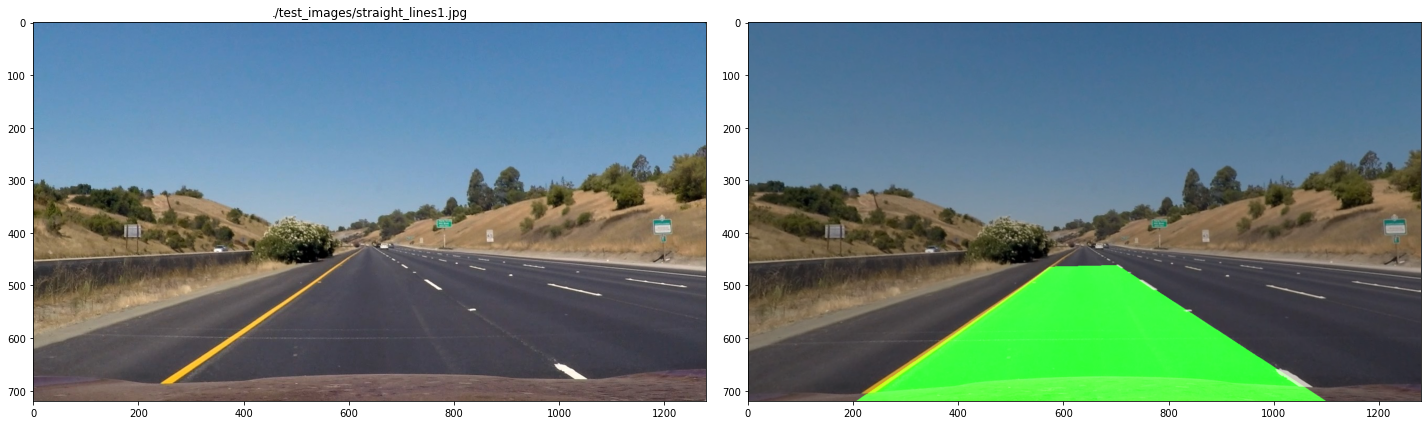

In [147]:
test_images = glob.glob('./test_images/*.jpg')
for img_file in test_images[0:1]:
    img = mpimg.imread(img_file)
    result = pipeline(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    fig.tight_layout()
    ax1.imshow(img)
    ax1.set_title(img_file)
    ax2.imshow(result)

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [116]:
def process_image(image, left_line, right_line):
    result = pipeline(image, left_line=left_line, right_line=right_line)
    return result

In [148]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
left_line = Line()
right_line = Line()
white_clip = clip1.fl_image(lambda im: process_image(im, left_line, right_line)) #NOTE: this function expects color images!!
%time white_clip.write_videofile("output_videos/project.mp4", audio=False)

t:   0%|          | 3/1260 [00:00<00:58, 21.49it/s, now=None]

Moviepy - Building video output_videos/project.mp4.
Moviepy - Writing video output_videos/project.mp4




t:  20%|█▉        | 251/1260 [00:17<01:04, 15.55it/s, now=None]


t:  39%|███▉      | 497/1260 [00:34<00:54, 13.91it/s, now=None]


t:  59%|█████▉    | 745/1260 [00:49<00:32, 15.90it/s, now=None]


t:  78%|███████▊  | 989/1260 [01:08<00:21, 12.71it/s, now=None]


t:  98%|█████████▊| 1231/1260 [01:26<00:01, 15.53it/s, now=None]


t:   0%|          | 1/1260 [63:30:30<79957:13:50, 228630.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready output_videos/project.mp4
CPU times: user 2min 29s, sys: 1min 12s, total: 3min 42s
Wall time: 1min 28s


In [149]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/project.mp4"))

In [125]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
left_line = Line()
right_line = Line()
challenge_clip = clip2.fl_image(lambda im: process_image(im, left_line, right_line)) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile("output_videos/challenge.mp4", audio=False)

t:   1%|          | 3/485 [00:00<00:17, 27.70it/s, now=None]

Moviepy - Building video output_videos/challenge.mp4.
Moviepy - Writing video output_videos/challenge.mp4




t:  53%|█████▎    | 256/485 [00:16<00:15, 14.66it/s, now=None]


t:   0%|          | 1/1260 [63:20:32<79747:54:08, 228032.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready output_videos/challenge.mp4
CPU times: user 54.8 s, sys: 25.2 s, total: 1min 19s
Wall time: 32 s


In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/challenge.mp4"))